In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from spacy import displacy
from sklearn.decomposition import PCA

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


## Load the data

In [2]:
train_data = pd.read_csv("../input/train.csv")

## Load the english spacy model

In [3]:
model = spacy.load("en_core_web_lg")

## First look

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float

## Select relevant columns and some samples for further analysis

- First of all, in this notebook I'm focusing on the comment text and the target variable
- To avoid long runtimes, I'm choosing a subset of the data

In [22]:
comments = train_data[['comment_text','target']].copy()
comments_sample = comments.sample(n=1000)
comments_sample.head()

,comment_text,target
1253762,Make Alberta 2004 again!!,0.00
85080,"With the owners' permission, I lived in a tipi...",0.00
1142596,"BTW Bubbles, Trump was inaugurated on January...",0.00
1371867,The confederacy was about slavery. The secess...,0.00
1501575,"You are a spiteful petty little man, aren't you?",0.35


## Apply the spcay model to each comment text

- The spacy model computes some metrics for the comment text
- To not loose the target and the id, both is saved with the comment metrics in a tuple

In [23]:
docs = []
for row in comments_sample.iterrows():
    doc = model(row[1][0])
    docs.append((doc, row[1][1], row[0]))

## Extract the tokens

- For each document, extract the tokens and some further info like POS...
- Save each token (with its correpsonding target and id) in a data frame

In [24]:
tokens = []

for (doc, target, _id) in docs:
    tokens.extend([(_id,\
                    target,\
                    token.text,\
                    token.lemma_,\
                    token.pos_,\
                    token.tag_,\
                    token.dep_,\
                    token.shape_,\
                    token.is_alpha,\
                    token.is_stop\
                   ) for token in doc])

tokens_df = pd.DataFrame(data = tokens, columns=['id','target','text','lemma','pos','tag','dep','shape','is_alpha', 'is_stop'])
print('Tokens Shape: {}'.format(tokens_df.shape))

Tokens Shape: (63912, 10)


In [25]:
tokens_df.sample(n=20)

,id,target,text,lemma,pos,tag,dep,shape,is_alpha,is_stop
7090,832773,0.166667,pepperettes,pepperette,NOUN,NNS,nsubj,xxxx,True,False
49656,918414,0.000000,people,people,NOUN,NNS,dobj,xxxx,True,False
38129,1731819,0.166667,any,any,DET,DT,det,xxx,True,True
27060,876873,0.000000,do,do,VERB,VBP,aux,xx,True,True
32534,1267174,0.000000,ahead,ahead,ADV,RB,advmod,xxxx,True,False
63751,621653,0.166667,one,one,NUM,CD,attr,xxx,True,True
20869,1428117,0.000000,.,.,PUNCT,.,punct,.,False,False
519,420538,0.166667,is,be,VERB,VBZ,ccomp,xx,True,True
47356,290436,0.500000,al,al,PROPN,NNP,pobj,xx,True,False
30570,1717996,0.000000,be,be,VERB,VB,auxpass,xx,True,True


# Inspect Nouns

- Now I'm only interested in nouns. So lets filter the token data frame and compute some aggregations
- The aggregations are computed over groups of 'lemma'.
- The count, just counts the occurences of the lemma in the samples
- The mean, computes the mean of the target variable. One token (lemma) can of course occur with a postive and/or negative variable. So the mean may distorting the truth.

In [27]:
noun_tokens_df = tokens_df[(tokens_df['pos'] == 'NOUN') & (tokens_df['is_alpha'] == True) & (tokens_df['is_stop'] == False)]
noun_tokens_df_counts = noun_tokens_df.groupby(by='lemma').agg({ 'target': 'mean', 'text': 'count'})

## Prepare the tokens for plotting

- For each token I'm fetching the correspondig vector representation.
- To plot the vector I have to reduce the dimensionality. For this, PCA with two components is applied

In [28]:
vectors = []
words = []
targets = []
counts = []


for doc, target, _id in docs:
    for token in doc:
        if token.has_vector and token.is_stop == False and token.pos_ == 'NOUN':
            product_count = tokens_df[tokens_df['text'] == token.text]['target'].unique().size            
            counts.append(product_count)
            targets.append(target)
            words.append(token.text)
            vectors.append(token.vector)
        
vec_df = pd.DataFrame(data = vectors, index=words)

pca = PCA(n_components=2)
red_vec = pca.fit_transform(vec_df.values)

vec_df['PC1'] = red_vec[:,0]
vec_df['PC2'] = red_vec[:,1]
vec_df['target'] = targets
vec_df['counts'] = counts
vec_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,PC1,PC2,target,counts
owners,0.28543,0.022999,-0.36573,-0.508640,-0.11716,-0.39856,0.69314,-0.34458,0.258400,2.65070,-0.389770,0.090722,-0.43281,-0.096470,-0.602570,-0.208570,-0.170830,0.75202,0.012742,-0.273190,-0.360400,-0.013397,0.60038,-0.556130,0.060485,0.041598,-0.035941,0.045481,-0.112000,0.11304,-0.24092,-0.232400,-0.289500,0.31941,-0.29613,0.46758,0.245280,-0.351610,-0.098147,-0.004687,...,-0.23032,-0.53298,0.273390,-0.48836,-0.10440,0.076195,0.19502,-0.27189,0.503600,-0.285440,0.095105,-0.749320,-0.46020,0.20083,-0.090121,-0.21937,-0.188150,0.32065,0.32619,0.47415,0.019656,0.22512,0.25087,0.30434,0.18648,0.464240,-1.36900,-0.45830,-0.101470,0.23632,0.17076,0.063428,-0.13929,-0.283650,0.193380,0.18846,0.602867,-1.209327,0.0,2
permission,0.29100,-0.759850,-0.64299,0.291560,-0.51062,0.64984,0.00488,-0.56417,-0.292130,2.39370,-0.410690,0.277080,0.19109,-0.067341,-0.018043,0.024216,-0.228360,0.98662,0.145280,0.196750,0.062952,-0.162510,-0.32595,0.086007,-0.370410,-0.213040,0.283170,-0.350810,-0.208010,-0.12228,-0.40317,0.099040,-0.146540,0.45875,-0.22107,-0.10379,0.074337,-0.055755,0.612390,-0.335570,...,0.11037,-0.11418,-0.293710,0.18307,0.65029,-0.539530,0.42751,-0.14992,0.579460,0.033179,0.176290,-0.094085,-0.10410,-0.14071,-0.051347,-0.46500,-0.218690,0.22645,0.42256,-0.15837,-0.384850,0.13235,-0.22862,0.58789,0.24734,-0.066808,-0.16076,-0.33350,-0.073801,0.18636,0.41741,-0.091921,-0.20979,0.056605,0.050115,0.18846,0.210840,-0.094318,0.0,2
tipi,1.00040,-0.418150,-0.27157,-0.036558,-0.29782,0.38136,0.62989,-0.38848,-0.445150,-0.51386,0.217820,-0.154110,-0.27364,0.149010,0.417870,0.108400,-0.086765,-0.29666,-0.021203,-0.035754,0.039149,-0.400430,0.11696,0.689400,0.396800,0.269080,-0.568820,0.047760,-0.131990,0.33792,0.49641,-0.516600,-0.028272,0.35671,0.57786,0.25953,-0.206360,0.147120,0.078869,-0.340020,...,-0.20320,0.15172,0.065978,-0.45233,-1.10740,0.061312,-0.66722,0.21614,0.056396,-0.667400,0.003860,0.120120,0.67027,0.22356,-0.026031,-0.43363,-0.634790,-0.20059,-0.97479,-0.81918,-0.384650,0.33469,0.00724,0.31073,0.31944,-0.131750,0.40065,-0.02260,-0.129110,-0.76384,-0.25061,0.466740,-0.49909,0.495070,-0.360180,-0.29475,-1.894399,1.037523,0.0,1
summers,0.50700,0.261310,0.48567,-0.053641,0.24259,0.37873,0.28913,0.28449,-0.336920,1.79520,-0.029416,-0.256430,-0.48819,-0.198270,0.039223,0.174730,0.285640,0.11563,0.306230,-0.021936,0.280130,-0.114400,-0.32058,0.307020,-0.392820,-0.170380,-0.422270,-0.038561,-0.164080,0.67579,0.16723,-0.261270,-0.160950,-0.45363,0.18898,0.16205,0.246550,-0.272450,-0.081615,0.203740,...,-0.25260,-0.14634,-0.425590,0.58532,-1.22820,0.245380,-0.52719,-0.15343,-0.126420,-0.261120,-0.301930,0.129010,0.01112,-0.21142,-0.054376,0.14187,0.481320,-0.14214,-0.56157,0.55124,0.544860,-0.10757,0.69466,-0.32675,0.18101,-0.180760,0.67213,0.32245,-0.346680,-0.26809,0.33326,-0.302890,-0.16825,-0.132360,-0.450950,-0.86269,-1.473003,-0.148585,0.0,1
canyon,0.16168,0.212130,-0.14541,-0.877760,0.53357,0.61305,-0.34602,0.92581,0.042275,1.26920,0.253260,-0.205000,0.30794,0.010367,-0.188680,0.413030,-0.021191,0.67242,0.274430,-0.253100,0.226610,0.047067,0.53079,0.247900,0.086847,0.591080,0.382990,0.771150,-0.021618,0.25058,0.36792,0.077403,0.226440,-0.31065,-0.46969,-0.14062,0.365250,-0.250610,-0.113700,0.519350,...,0.67986,-0.99909,0.144590,-0.10266,-1.00080,0.287180,-0.79357,0.72624,-0.009545,-0.318700,0.289770,-0.459260,-0.19552,-0.38842,-0.076598,-0.86676,0.071874,-0.62761,-0.48367,0.31149,0.034902,-0.14369,0.43066,0.67861,0.69155,-0.446480,-0.45821,0.18438,-0.097837,-0.23867,0.20728,-0.158240,0.23670,0.146790,-0.081807,-0.48267,-1.712026,-0.122759,0.0,1


## Plot nouns with target mean >= 0.5

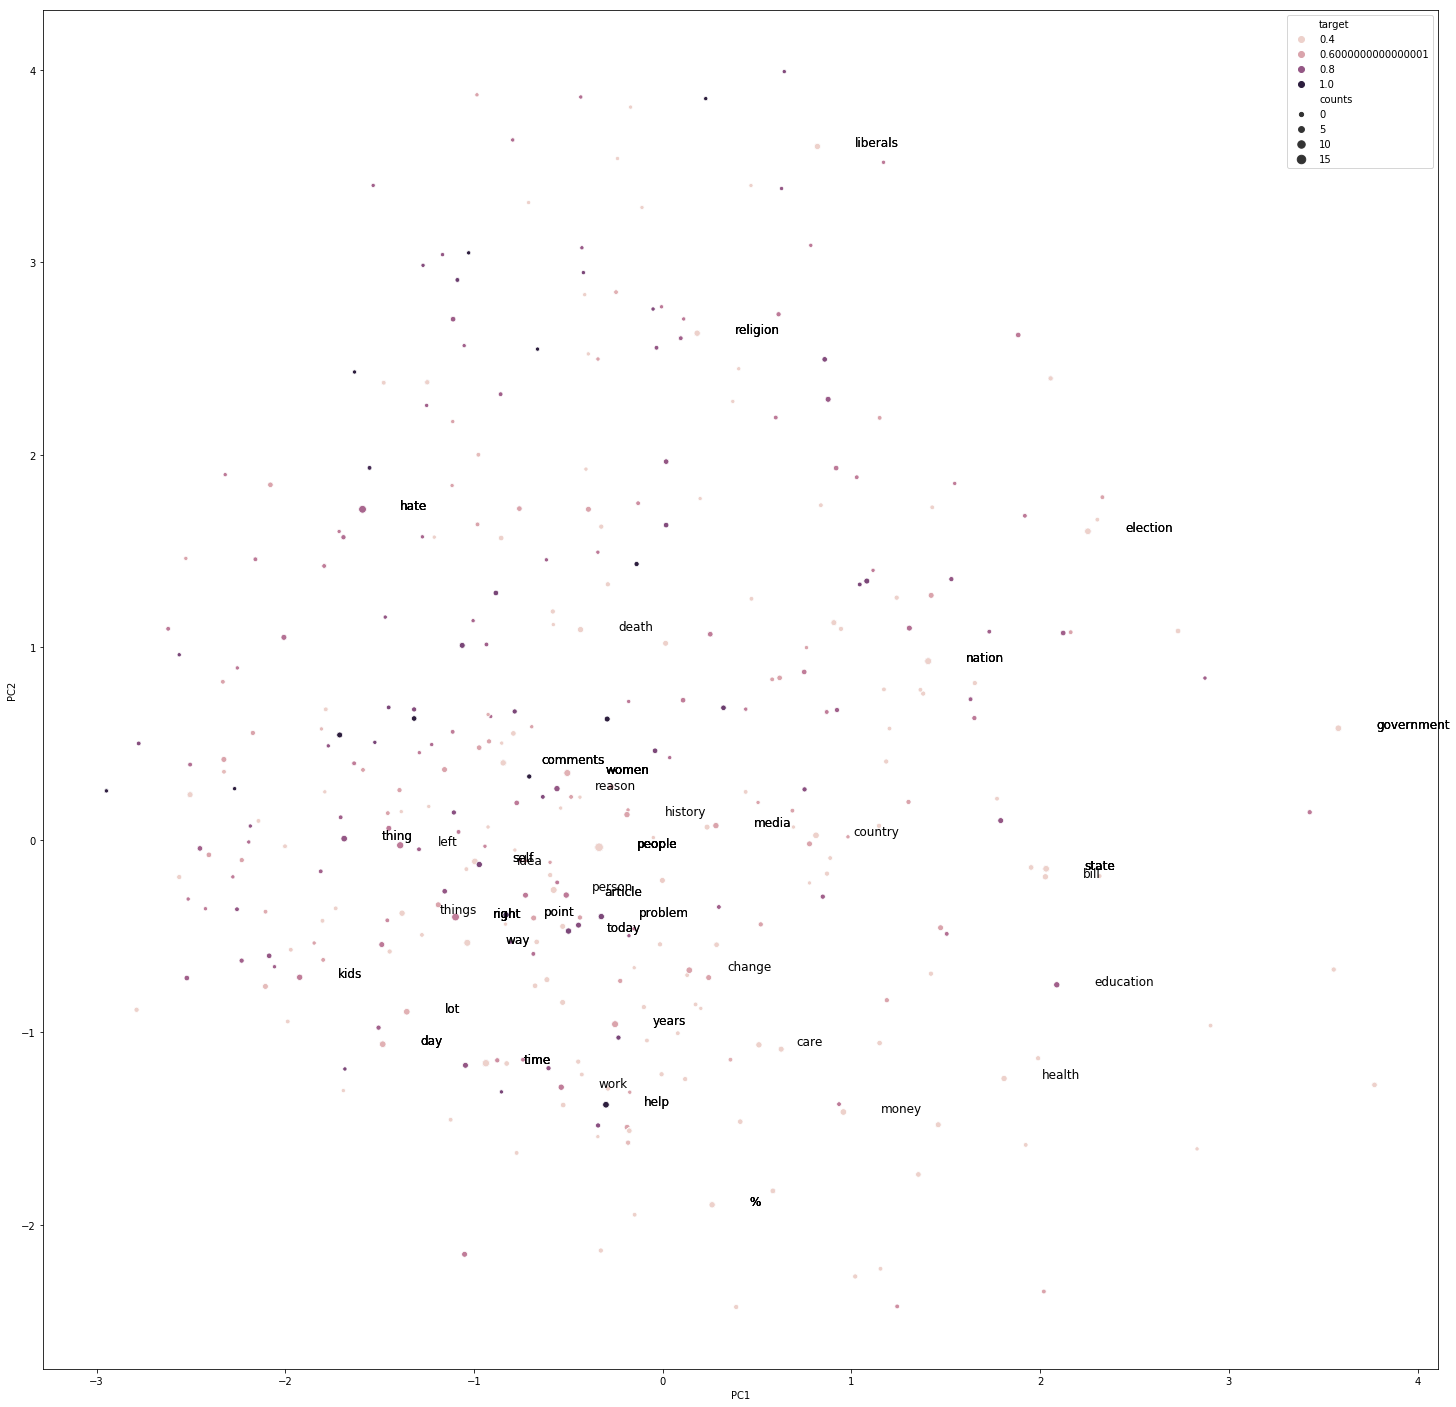

In [32]:
vec_df_pos = vec_df[vec_df['target'] >= 0.5]
plt.figure(figsize=(25,25))
p1 = sns.scatterplot(x='PC1', y='PC2', size='counts', hue='target', data=vec_df_pos)

for line in range(0,vec_df_pos.shape[0]):
    if vec_df_pos.counts[line] > 5: 
        p1.text(vec_df_pos.PC1[line]+0.2, vec_df_pos.PC2[line], vec_df_pos.index[line], horizontalalignment='left', size='large', color='black')

## Plot nouns with target < 0.5

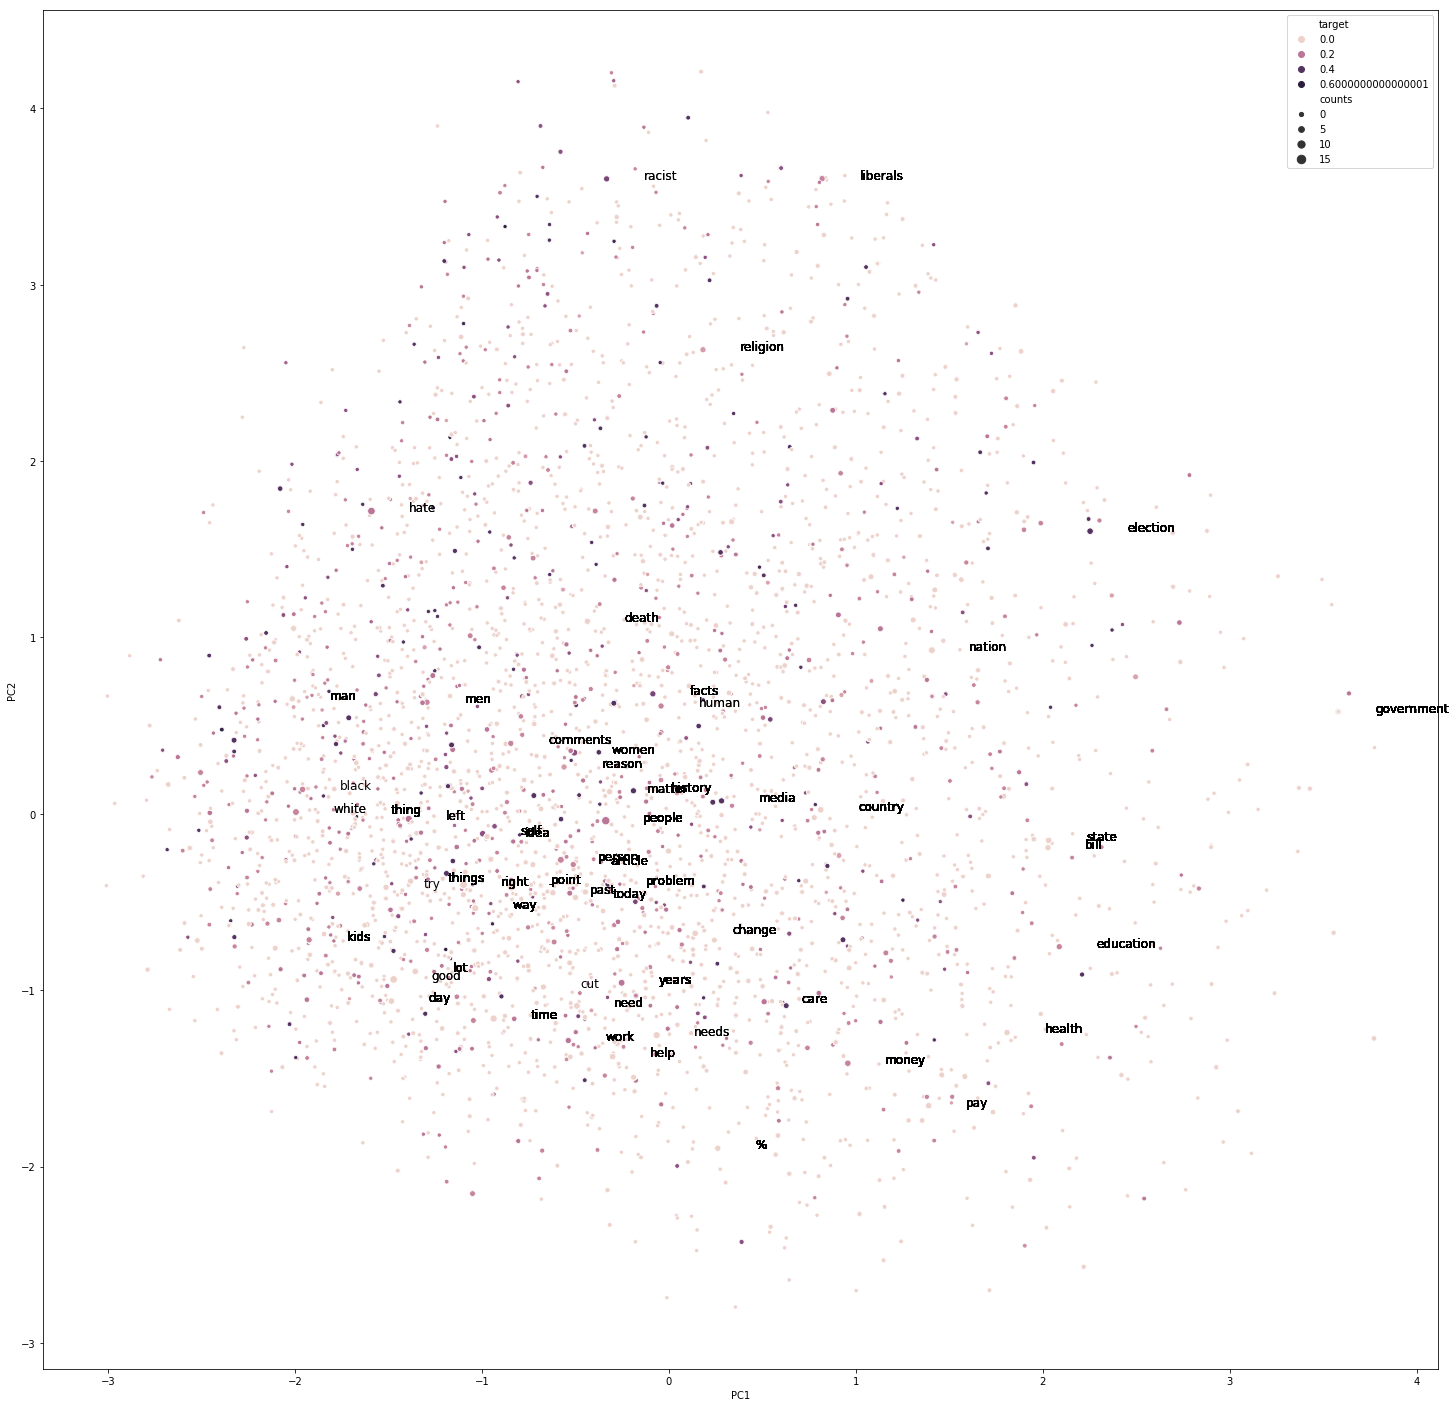

In [31]:
vec_df_neg = vec_df[vec_df['target'] < 0.5]
plt.figure(figsize=(25,25))
p1 = sns.scatterplot(x='PC1', y='PC2', size='counts', hue='target', data=vec_df_neg)

for line in range(0,vec_df_neg.shape[0]):
    if vec_df_neg.counts[line] > 5: 
        p1.text(vec_df_neg.PC1[line]+0.2, vec_df_neg.PC2[line], vec_df_neg.index[line], horizontalalignment='left', size='large', color='black')

## Findings

- After some runs, it seems, that negative nouns seem to be more present in targets >= 0.5
- But that's just a first impression and a very subjective too :-)
- In further analysis I want to look at verbs and adjectives in the same way. Also I want to compute the TF/IDF to get other insights
- .....